In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/waste-classification.zip

In [4]:
from glob import glob
O_1 = glob("/content/DATASET/train/O/*.jpg")
R_1 = glob('/content/DATASET/train/R/*.jpg')

In [5]:
from sklearn.model_selection import train_test_split
O_train, O_test = train_test_split(O_1, test_size=0.20)
R_train, R_test = train_test_split(R_1, test_size=0.20)

In [6]:
!mkdir "/content/DATASET/val"

!mkdir "/content/DATASET/val/O"
files = ' '.join(O_test)
!mv -t "/content/DATASET/val/O" $files

!mkdir "/content/DATASET/val/R"
files = ' '.join(R_test)
!mv -t "/content/DATASET/val/R" $files

In [7]:
!pip install pennylane

     |████████████████████████████████| 409kB 7.5MB/s 
  Created wheel for pennylane: filename=PennyLane-0.14.1-cp37-none-any.whl size=481980 sha256=ea5b59a869d66d36db52934ed7fb8c22162b6c89e2c22e590cf8ce5e0952a5f4
  Stored in directory: /root/.cache/pip/wheels/6e/a9/c9/04941d6dd58b3c111cbd1389bf63ba1b23362c137359af4626
Successfully built pennylane


In [8]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [9]:
n_qubits = 4              # Number of qubits
step = 0.0007          # Learning rate
batch_size = 4            # Number of samples for each training step
num_epochs = 1              # Number of training epochs
q_depth = 4              # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
rng_seed = 3                # Seed for random number generator
start_time = time.time()    # Start of the computation timer

In [10]:
dev = qml.device("default.qubit", wires=n_qubits)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "predict": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/DATASET"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes
print(dataset_sizes)

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}
print(class_names)
# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

{'train': 18051, 'validation': 4513}
['O', 'R']


tensor([1, 0, 0, 1])


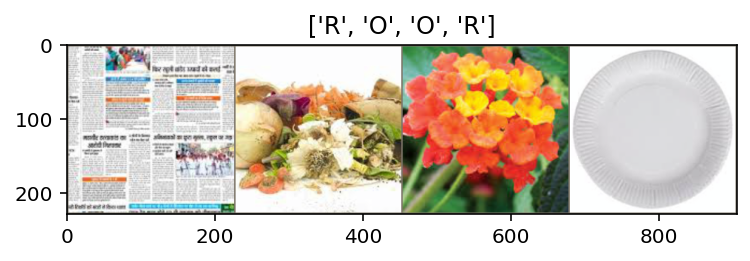

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# In order to get reproducible results, we set a manual seed for the
# random number generator and re-initialize the dataloaders.

torch.manual_seed(rng_seed)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [15]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    #print(w)
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def RZ_layer(w):
    """Layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [33]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RZ_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    #exp_vals=qml.expval(qml.PauliZ(0))
    return tuple(exp_vals)

In [34]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net=nn.Linear(1664,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [35]:
model_hybrid=torchvision.models.densenet169(pretrained=True)
#model_hybrid1=torchvision.models.densenet161(pretrained=True)
for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.classifier=DressedQuantumNet()
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [ ]:
model_hybrid

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
optimizer_hybrid = optim.Adam(model_hybrid.classifier.parameters(), lr=step)

In [39]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [40]:
model_hybrid.load_state_dict(torch.load('/content/drive/MyDrive/FYP/Final/wts-WASTE-CLASSIFICATION-quantum pauli z-Final-results.h5'))

<All keys matched successfully>

In [43]:
#transform
from PIL import Image
img = Image.open('/content/R_9300.jpg')
img  = data_transforms["predict"](img)

img = img.unsqueeze(0) #since not a batch

model_hybrid.eval()

# Get prediction
img = img.type(torch.cuda.FloatTensor)
output = model_hybrid(img)
#print(output)
_, preds = torch.max(output, 1)
#print(preds)
print(class_names[preds[0]])

tensor([[-1.0453,  0.6833]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1], device='cuda:0')
R


In [ ]:
!pip install flask-ngrok

In [50]:
import os
import io
import json
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, request, redirect, url_for, render_template
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename

app = Flask(__name__,template_folder="/content/drive/MyDrive/WebApp/template")
run_with_ngrok(app)

@app.route('/', methods=['GET', 'POST']) 
def main_page():
    if request.method == 'POST':
        file = request.files['file']
        filename = secure_filename(file.filename)
        file.save(os.path.join('/content/drive/MyDrive/WebApp/uploads', filename))
        return redirect(url_for('prediction', filename=filename))
    return render_template('index.html')

@app.route('/prediction/<filename>') 
def prediction(filename):
    from PIL import Image
    img = Image.open(os.path.join('/content/drive/MyDrive/WebApp/uploads', filename))
    img  = data_transforms["predict"](img)
    img = img.unsqueeze(0) #since not a batch
    model_hybrid.eval()

    # Get prediction
    img = img.type(torch.cuda.FloatTensor)
    output = model_hybrid(img)
    #print(output)
    _, preds = torch.max(output, 1)
    #print(preds)
    #print(class_names[preds[0]])
    if class_names[preds[0]]=='O':
      name = "Organic"
    else : 
      name = "Recyclable"
    predictions = {
        "class1":name
      }
    #Step 5
    return render_template('predict.html', predictions=predictions)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2a560152d67f.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [18/Mar/2021 08:26:22] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Mar/2021 08:26:25] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [18/Mar/2021 08:26:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [18/Mar/2021 08:26:50] "POST / HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [18/Mar/2021 08:26:50] "GET /prediction/O_8.jpg HTTP/1.1" 200 -
